# 서울시 4~6월 자전거 대여 데이터를 기반으로 평일 5일의 일별 대여소별 자전거 배치 수 예측

# 1. 데이터 로드 및 전처리
## 데이터 불러오기: 서울시 공공자전거 대여 이력 데이터

In [1]:
import pandas as pd
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
import warnings

# 모든 경고를 무시
warnings.filterwarnings('ignore')

In [2]:
df1 = pd.read_csv('data/서울특별시 공공자전거 대여이력 정보_2405.csv', encoding='cp949')
df2 = pd.read_csv('data/서울특별시 공공자전거 대여이력 정보_2406.csv', encoding='cp949')
df3 = pd.read_csv('data/서울특별시 공공자전거 대여이력 정보_2404.csv', encoding='cp949')
df = pd.concat([df1, df2, df3], ignore_index=True)

## 시간 형식 변환: 대여일시와 반납일시를 datetime 형식

In [3]:
df['대여일시'] = pd.to_datetime(df['대여일시'])
df['반납일시'] = pd.to_datetime(df['반납일시'])

In [6]:
df.head()

,자전거번호,대여일시,대여 대여소번호,대여 대여소명,대여거치대,반납일시,반납대여소번호,반납대여소명,반납거치대,이용시간(분),이용거리(M),생년,성별,이용자종류,대여대여소ID,반납대여소ID,자전거구분
0,SPB-84535,2024-05-01 00:00:16,540,군자역 7번출구 베스트샵 앞,99,2024-05-01 00:00:31,00540,군자역 7번출구 베스트샵 앞,99,0,0.00,1997,F,내국인,ST-253,ST-253,새싹자전거
1,SPB-30613,2024-05-01 00:00:33,540,군자역 7번출구 베스트샵 앞,0,2024-05-01 00:00:43,00540,군자역 7번출구 베스트샵 앞,0,0,0.00,1997,M,내국인,ST-253,ST-253,일반자전거
2,SPB-36047,2024-05-01 00:00:40,2644,성내5교,0,2024-05-01 00:01:09,02644,성내5교,0,0,0.00,1962,\N,내국인,ST-1796,ST-1796,일반자전거
3,SPB-38596,2024-05-01 00:00:22,1480,용마지구대 B,0,2024-05-01 00:01:26,01479,면목 홈플러스 2,0,1,176.24,1989,\N,내국인,ST-2301,ST-2300,일반자전거
4,SPB-66912,2024-05-01 00:01:08,4332,이수교차로,0,2024-05-01 00:01:30,04332,이수교차로,0,0,0.00,\N,F,내국인,ST-3086,ST-3086,일반자전거


In [23]:
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# 대여일시를 datetime 형식으로 변환
df['대여일시'] = pd.to_datetime(df['대여일시'])

# 요일 정보 추출 (0: 월요일, 6: 일요일)
df['대여요일'] = df['대여일시'].dt.dayofweek

# 주말 여부 판단 (5: 토요일, 6: 일요일)
df['주말'] = df['대여요일'].apply(lambda x: '주말' if x >= 5 else '평일')

# 주말과 평일 그룹의 대여 횟수 계산
주말_대여횟수 = df[df['주말'] == '주말'].groupby('자전거번호').size().reset_index(name='대여횟수')
평일_대여횟수 = df[df['주말'] == '평일'].groupby('자전거번호').size().reset_index(name='대여횟수')

# 주말과 평일을 구분하기 위한 열 추가
주말_대여횟수['구분'] = '주말'
평일_대여횟수['구분'] = '평일'

# Two-sample t-test (대여횟수 열만 사용)
t_stat, p_value = stats.ttest_ind(주말_대여횟수['대여횟수'], 평일_대여횟수['대여횟수'], equal_var=False)

# 결과 출력 (p-value를 소수점 4자리로 표시)
print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value:.4f}')

T-statistic: -238.81852419310673
P-value: 0.0000


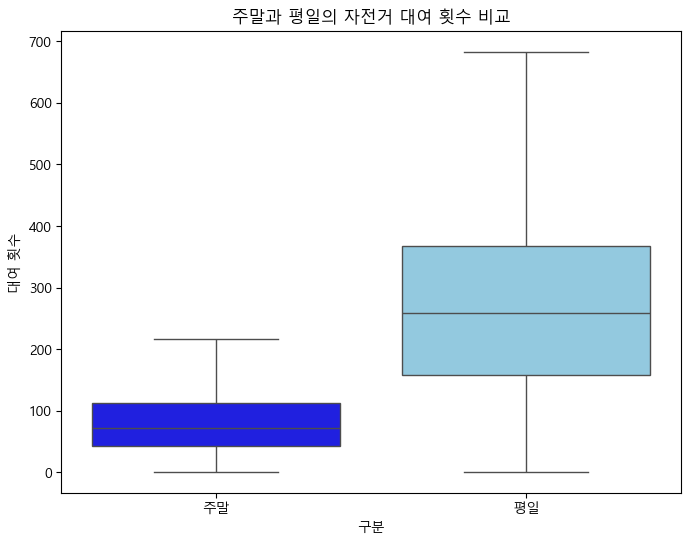

In [21]:
# Boxplot 그리기 (이상치 표시 안 함, 주말과 평일의 색상 다르게 설정)
plt.figure(figsize=(8, 6))
sns.boxplot(x='구분', y='대여횟수', data=df_합침, showfliers=False, palette={"주말": "blue", "평일": "skyblue"})
plt.title('주말과 평일의 자전거 대여 횟수 비교')
plt.xlabel('구분')
plt.ylabel('대여 횟수')
plt.show()

In [10]:
len(df1) # 5월 대여수 18675 : 0.377

4947830

In [11]:
len(df2) # 6월 대여수 18628 : 0.372

5004330

In [24]:
len(df3) # 4월 대여수

4750308

In [4]:
len(df)

14702468

In [25]:
주말_대여횟수['대여횟수'].mean()

82.00611583538412

In [26]:
평일_대여횟수['대여횟수'].mean()

274.8728299873921

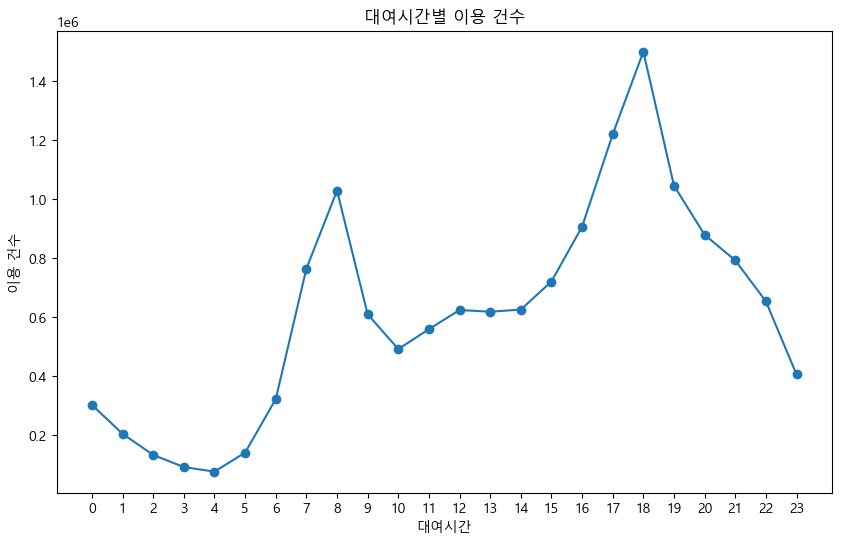

In [7]:
df['대여시간'] = df['대여일시'].dt.hour

# '이용시간(분)'별로 행 수를 계산
usage_time_counts = df['대여시간'].value_counts().reset_index()

# 열 이름 변경
usage_time_counts.columns = ['대여시간', 'count']

# '이용시간(분)' 순으로 정렬
usage_time_counts = usage_time_counts.sort_values('대여시간')

# 꺾은선 그래프 그리기
plt.figure(figsize=(10, 6))
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.plot(usage_time_counts['대여시간'], usage_time_counts['count'], marker='o', linestyle='-')
plt.title('대여시간별 이용 건수')
plt.xlabel('대여시간')
plt.ylabel('이용 건수')
#plt.grid(True)
plt.xticks(usage_time_counts['대여시간'])
plt.show()

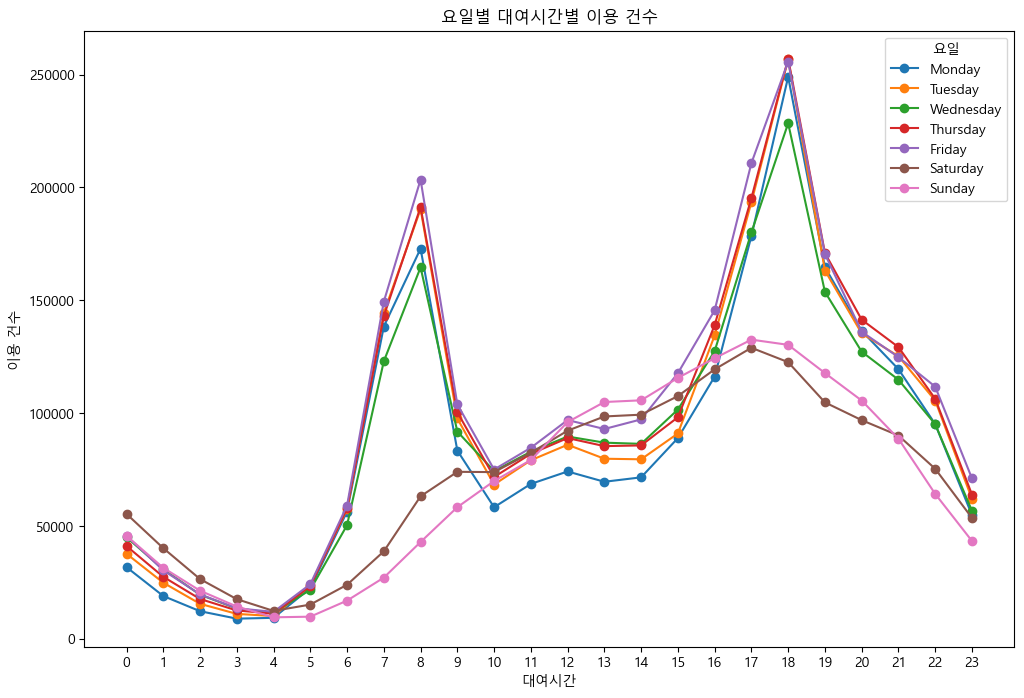

In [8]:
# 1. '대여일시'에서 요일 추출
df['요일'] = df['대여일시'].dt.day_name()

# 2. 요일별, 대여시간별 행 수 계산
usage_time_counts = df.groupby(['요일', '대여시간']).size().reset_index(name='count')

# 3. 요일별 데이터 정렬 (요일 순서가 월요일부터 일요일까지 나올 수 있도록)
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
usage_time_counts['요일'] = pd.Categorical(usage_time_counts['요일'], categories=days_order, ordered=True)

# 4. 요일별로 꺾은선 그래프 그리기
plt.figure(figsize=(12, 8))
plt.rcParams['font.family'] = 'Malgun Gothic'

for day in days_order:
    day_data = usage_time_counts[usage_time_counts['요일'] == day]
    plt.plot(day_data['대여시간'], day_data['count'], marker='o', linestyle='-', label=day)

plt.title('요일별 대여시간별 이용 건수')
plt.xlabel('대여시간')
plt.ylabel('이용 건수')
plt.legend(title='요일')
plt.xticks(usage_time_counts['대여시간'].unique())
plt.show()

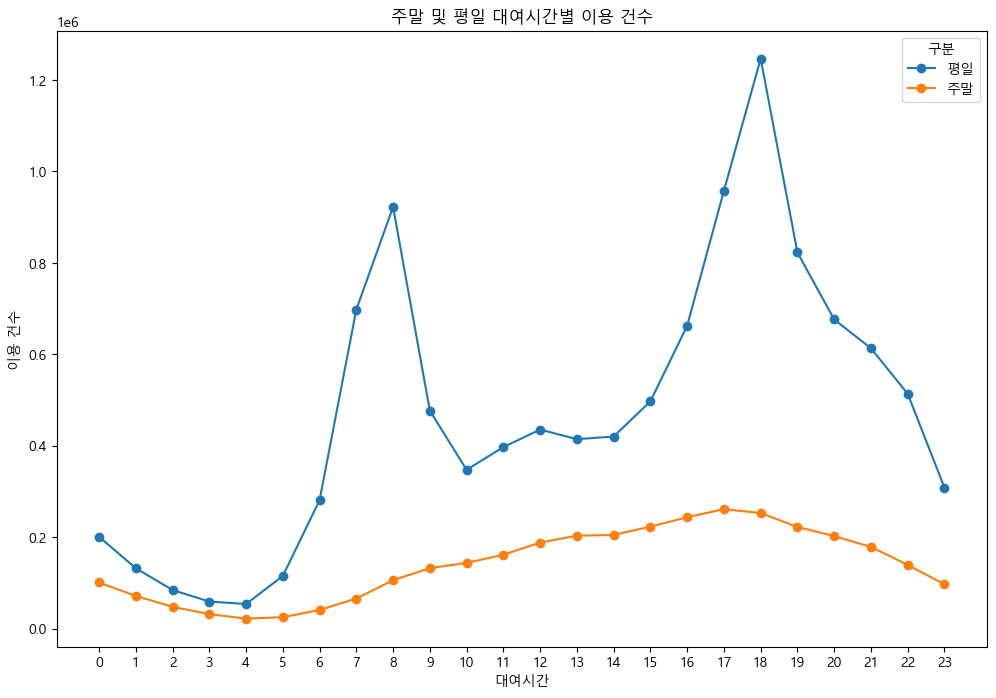

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. '대여일시'에서 요일 추출
df['요일'] = df['대여일시'].dt.day_name()

# 2. 주말 여부 판단 (주말: Saturday, Sunday)
df['구분'] = df['요일'].apply(lambda x: '주말' if x in ['Saturday', 'Sunday'] else '평일')

# 3. 주말/평일별, 대여시간별 행 수 계산
usage_time_counts = df.groupby(['구분', '대여시간']).size().reset_index(name='count')

# 4. 주말과 평일로 꺾은선 그래프 그리기
plt.figure(figsize=(12, 8))
plt.rcParams['font.family'] = 'Malgun Gothic'

for category in ['평일', '주말']:
    category_data = usage_time_counts[usage_time_counts['구분'] == category]
    plt.plot(category_data['대여시간'], category_data['count'], marker='o', linestyle='-', label=category)

plt.title('주말 및 평일 대여시간별 이용 건수')
plt.xlabel('대여시간')
plt.ylabel('이용 건수')
plt.legend(title='구분')
plt.xticks(usage_time_counts['대여시간'].unique())
plt.show()

In [11]:
df.groupby(['구분', '대여시간']).size().reset_index(name='count').head()

,구분,대여시간,count
0,주말,0,100878
1,주말,1,71536
2,주말,2,47712
3,주말,3,31783
4,주말,4,21794


In [13]:
# 대여 대여소명을 포함한 지점별 대여수 데이터셋 생성
station_rental_counts = pd.merge(station_rental_counts, df[['대여 대여소번호', '대여 대여소명']].drop_duplicates(), on='대여 대여소번호')
# 대여수가 많은 순서로 정렬
station_rental_counts_sorted = station_rental_counts.sort_values(by='대여수', ascending=False)
station_rental_counts_sorted

,대여 대여소번호,대여수,대여 대여소명
2235,4217,56049,한강공원 망원나들목
1724,2715,54819,마곡나루역 2번 출구
327,502,53758,자양(뚝섬한강공원)역 1번출구 앞
838,1210,42479,롯데월드타워(잠실역2번출구 쪽)
1735,2728,37799,마곡나루역 3번 출구
...,...,...,...
1841,3306,146,서울신우초등학교
2273,4314,100,탑성마을 버스정거장 옆
1904,3538,98,서울숲 IT캐슬
2293,4343,97,헌인릉 입구


## 요일 추가 및 평일 필터링

In [4]:
df['요일'] = df['대여일시'].dt.dayofweek
df = df[df['요일'] < 5].copy()

## 7시-9시 대여량 집계

In [5]:
morning_rush_df = df[(df['대여일시'].dt.hour >= 7) & (df['대여일시'].dt.hour < 9)]
morning_rush_df.loc[:, '대여일'] = morning_rush_df['대여일시'].dt.date
daily_rush_df = morning_rush_df.groupby(['대여 대여소번호', '대여일']).size().reset_index(name='7시-9시 대여량')

C:\Users\campus4D033\AppData\Local\Temp\ipykernel_9972\1969688551.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morning_rush_df.loc[:, '대여일'] = morning_rush_df['대여일시'].dt.date


## 전체 데이터와 병합

In [6]:
df.loc[:, '대여일'] = df['대여일시'].dt.date
df = df.merge(daily_rush_df, on=['대여 대여소번호', '대여일'], how='left')


## '이용시간(분)'과 '이용거리(M)' 열의 데이터를 숫자로 변환

In [7]:
df['이용시간(분)'] = pd.to_numeric(df['이용시간(분)'], errors='coerce')
df['이용거리(M)'] = pd.to_numeric(df['이용거리(M)'], errors='coerce')
df = df[(df['이용시간(분)'] > 0) & (df['이용거리(M)'] > 0)]
df['7시-9시 대여량'].fillna(0, inplace=True)


# 2. 모델 학습 및 하이퍼파라미터 튜닝
## 대여소별 데이터 특성 계산: 대여소별 하루 단위 데이터의 평균값을 계산하고 대여횟수를 추가

In [8]:
station_data = df.groupby('대여 대여소번호').agg({
    '7시-9시 대여량': 'mean',
    '이용시간(분)': 'mean',
    '이용거리(M)': 'mean'
}).reset_index()

rental_count = df.groupby('대여 대여소번호')['자전거번호'].count().reset_index()
rental_count.columns = ['대여 대여소번호', '총 대여횟수']
station_data = station_data.merge(rental_count, on='대여 대여소번호', how='left')

## 특성과 목표 변수 설정: 특성(X)과 목표 변수(y)를 설정

In [9]:
X = station_data[['이용시간(분)', '이용거리(M)', '총 대여횟수']]
y = station_data['7시-9시 대여량']
y = y.dropna()
X = X.loc[y.index]

## 학습 및 테스트 데이터 분리: 학습 데이터와 테스트 데이터를 분리

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## GridSearchCV를 통한 하이퍼파라미터 튜닝

In [11]:
model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

## 최적 모델 평가

In [12]:
print(f'Best parameters: {grid_search.best_params_}')
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse:.4f}')
print(f'R^2 Score: {r2:.4f}')


Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mean Squared Error: 40.9948
R^2 Score: 0.6027


## 자전거 배치 수 예측

In [13]:
station_data['예측된 자전거 배치 수'] = best_model.predict(X)
print("대여소별 자전거 배치 예측 결과:")
print(station_data.head())


대여소별 자전거 배치 예측 결과:
   대여 대여소번호  7시-9시 대여량    이용시간(분)      이용거리(M)  총 대여횟수  예측된 자전거 배치 수
0       102  13.484208  26.611225  2579.990947   10227     16.075015
1       103   6.052335  29.574161  2961.915574    8522      8.645478
2       104   5.758229  30.900259  3106.329599    5013      6.540822
3       105   1.689821  30.370702  3174.797937    2908      4.601085
4       106   6.950579  36.886219  4427.872948    8033      7.377458


# 전체 코드

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 데이터 불러오기
df1 = pd.read_csv('서울특별시 공공자전거 대여이력 정보_2405.csv', encoding='cp949')
df2 = pd.read_csv('서울특별시 공공자전거 대여이력 정보_2406.csv', encoding='cp949')
df3 = pd.read_csv('서울특별시 공공자전거 대여이력 정보_2404.csv', encoding='cp949')

df = pd.concat([df1, df2, df3], ignore_index=True)

# 대여일시를 datetime으로 변환
df['대여일시'] = pd.to_datetime(df['대여일시'])
df['반납일시'] = pd.to_datetime(df['반납일시'])

# 요일 열 추가 (0=월요일, ..., 6=일요일)
df['요일'] = df['대여일시'].dt.dayofweek

# 평일(월-금)만 필터링
df = df[df['요일'] < 5].copy()

# 7시에서 9시 사이 대여된 기록 필터링
morning_rush_df = df[(df['대여일시'].dt.hour >= 7) & (df['대여일시'].dt.hour < 9)]

# 하루 단위로 7시-9시 대여량 계산
morning_rush_df.loc[:, '대여일'] = morning_rush_df['대여일시'].dt.date
daily_rush_df = morning_rush_df.groupby(['대여 대여소번호', '대여일']).size().reset_index(name='7시-9시 대여량')

# 대여일시를 날짜만 남기기 위해 '대여일시'의 날짜 부분만 사용
df.loc[:, '대여일'] = df['대여일시'].dt.date

# 전체 데이터와 병합
df = df.merge(daily_rush_df, on=['대여 대여소번호', '대여일'], how='left')

# '이용시간(분)'과 '이용거리(M)' 열의 데이터 타입을 숫자로 변환
df['이용시간(분)'] = pd.to_numeric(df['이용시간(분)'], errors='coerce')
df['이용거리(M)'] = pd.to_numeric(df['이용거리(M)'], errors='coerce')

# 0인 경우 삭제
df = df[(df['이용시간(분)'] > 0) & (df['이용거리(M)'] > 0)]

# 결측값을 0으로 채우기 (또는 다른 방법으로 처리 가능)
df['7시-9시 대여량'].fillna(0, inplace=True)

# 대여소별 하루 단위 데이터 특성 계산
station_data = df.groupby('대여 대여소번호').agg({
    '7시-9시 대여량': 'mean',
    '이용시간(분)': 'mean',
    '이용거리(M)': 'mean'
}).reset_index()

# 대여소별 대여횟수 계산
rental_count = df.groupby('대여 대여소번호')['자전거번호'].count().reset_index()
rental_count.columns = ['대여 대여소번호', '총 대여횟수']

# 대여횟수와 병합
station_data = station_data.merge(rental_count, on='대여 대여소번호', how='left')

# 특성과 목표 변수 설정
X = station_data[['이용시간(분)', '이용거리(M)', '총 대여횟수']]
y = station_data['7시-9시 대여량']

# NaN 값이 있는지 확인하고 제거
y = y.dropna()
X = X.loc[y.index]  # X와 y의 인덱스를 동기화하여 NaN이 있는 행 제거

# 학습 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RandomForestRegressor 모델과 하이퍼파라미터 그리드 정의
model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GridSearchCV 객체 생성
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# 모델 학습
grid_search.fit(X_train, y_train)

# 최적의 파라미터 출력
print(f'Best parameters: {grid_search.best_params_}')

# 최적 모델로 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.4f}')
print(f'R^2 Score: {r2:.4f}')

# 예측된 자전거 배치 수
station_data['예측된 자전거 배치 수'] = best_model.predict(X)

# 결과 확인
print("대여소별 자전거 배치 예측 결과:")
print(station_data.head())


C:\Users\campus4D033\AppData\Local\Temp\ipykernel_9972\718456266.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morning_rush_df.loc[:, '대여일'] = morning_rush_df['대여일시'].dt.date


Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mean Squared Error: 40.9948
R^2 Score: 0.6027
대여소별 자전거 배치 예측 결과:
   대여 대여소번호  7시-9시 대여량    이용시간(분)      이용거리(M)  총 대여횟수  예측된 자전거 배치 수
0       102  13.484208  26.611225  2579.990947   10227     16.075015
1       103   6.052335  29.574161  2961.915574    8522      8.645478
2       104   5.758229  30.900259  3106.329599    5013      6.540822
3       105   1.689821  30.370702  3174.797937    2908      4.601085
4       106   6.950579  36.886219  4427.872948    8033      7.377458
